In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [2]:
md = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/soft_label.tsv', sep='\t', index_col=0)
md.shape

(811, 42)

In [6]:
# import data
brca_df = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/soft_label.tsv', sep='\t', index_col=0)
brca_raw = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/toga.breast.brca.status.txt', sep='\t', index_col=0)
rnaseq_df = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)
hrd_df = pd.read_excel('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/tcga.hrdscore.xlsx')
print(brca_df.shape)
print(rnaseq_df.shape)
print(brca_raw.shape)
print(hrd_df.shape)

(811, 42)
(1231, 60663)
(992, 33)
(9604, 5)


In [4]:

# Drop rows where event.BRCA1 is '1'
brca_df_filtered = brca_df[brca_df['event.BRCA1'] != '1']

# Drop rows where event.BRCA2 is 'Bi-allelic-undetermined'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.BRCA2'] != 'Bi-allelic-undetermined']

# Drop rows where event.PALB2 is '2'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.PALB2'] != '2']

# keep common samples

#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(rnaseq_df['Case ID'])
brca_samples = set(brca_df_filtered.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(brca_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))

# Drop samples that are not common in all three dataframes
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]
brca_df_common = brca_df_filtered[brca_df_filtered.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("brca_df_common:", brca_df_common.shape)


Number of common samples: 811
rnaseq_df_common: (872, 60663)
brca_df_common: (811, 42)


In [5]:
# Check for duplicates in rnaseq_df_common's Case ID
print("Duplicate Case IDs in rnaseq_df:", rnaseq_df_common['Case ID'].duplicated().sum())

# Drop duplicates in rnaseq_df_common if any
rnaseq_df_common = rnaseq_df_common.drop_duplicates(subset=['Case ID'])

# Verify the shapes after removing duplicates
print("\nAfter removing duplicates:")
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("brca_df_common:", brca_df_common.shape)

# Verify that we have exactly the same samples in both dataframes
rnaseq_samples = set(rnaseq_df_common['Case ID'])
brca_samples = set(brca_df_common.index)
print("\nSamples match:", rnaseq_samples == brca_samples)
print("Number of samples in each:", len(rnaseq_samples), len(brca_samples))

Duplicate Case IDs in rnaseq_df: 61

After removing duplicates:
rnaseq_df_common: (811, 60663)
brca_df_common: (811, 42)

Samples match: True
Number of samples in each: 811 811


In [6]:
rnaseq_df_common.head()

,Case ID,Sample ID,Sample Type,ENSG00000000003.15|TSPAN6|protein_coding,ENSG00000000005.6|TNMD|protein_coding,ENSG00000000419.13|DPM1|protein_coding,ENSG00000000457.14|SCYL3|protein_coding,ENSG00000000460.17|C1orf112|protein_coding,ENSG00000000938.13|FGR|protein_coding,ENSG00000000971.16|CFH|protein_coding,...,ENSG00000288661.1|AL451106.1|protein_coding,ENSG00000288662.1|AC092910.4|lncRNA,ENSG00000288663.1|AC073611.1|lncRNA,ENSG00000288665.1|AC136977.1|lncRNA,ENSG00000288667.1|AC078856.1|lncRNA,ENSG00000288669.1|AC008763.4|protein_coding,ENSG00000288670.1|AL592295.6|lncRNA,ENSG00000288671.1|AC006486.3|protein_coding,ENSG00000288674.1|AL391628.1|protein_coding,ENSG00000288675.1|AP006621.6|protein_coding
0,TCGA-E9-A1RH,TCGA-E9-A1RH-01A,Primary Tumor,1.0276,0.0000,74.2709,1.3816,1.6749,1.4166,5.2410,...,0.0,0.0,0.0177,0.0,0.0,0.0000,1.8073,0.0,0.0000,0.1285
1,TCGA-C8-A26W,TCGA-C8-A26W-01A,Primary Tumor,13.2684,0.1250,37.9298,3.7360,3.1045,2.4799,7.4851,...,0.0,0.0,0.0847,0.0,0.0,0.0036,3.4634,0.0,0.0074,0.3801
3,TCGA-AO-A0JJ,TCGA-AO-A0JJ-01A,Primary Tumor,14.8681,2.2172,27.8838,4.3170,1.7847,3.7167,9.6630,...,0.0,0.0,0.0261,0.0,0.0,0.0000,3.2723,0.0,0.0058,0.2546
4,TCGA-BH-A0HO,TCGA-BH-A0HO-01A,Primary Tumor,0.8430,0.0798,22.1105,3.9971,0.9805,2.4742,3.8185,...,0.0,0.0,0.0253,0.0,0.0,0.0000,3.1233,0.0,0.0041,0.4599
5,TCGA-BH-A18F,TCGA-BH-A18F-01A,Primary Tumor,10.1027,8.2031,29.6694,5.2897,3.2049,2.8792,10.0696,...,0.0,0.0,0.0412,0.0,0.0,0.0000,5.5897,0.0,0.0067,0.6483


In [7]:
# filter to top 2 percent of differentially expressed genes
deseq_results=pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/deseq_bottom_2_percent.tsv', sep = '\t', index_col=0)



deseq_results.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000163975.12|MELTF|protein_coding,4.223192,2.197306,0.122265,17.971715,3.245282e-72,6.764141e-68
ENSG00000115163.15|CENPA|protein_coding,4.405742,1.489792,0.087457,17.034565,4.551128e-65,4.742959e-61
ENSG00000107937.19|GTPBP4|protein_coding,13.539092,0.820738,0.048266,17.004536,7.600421e-65,5.280519e-61
ENSG00000136943.11|CTSV|protein_coding,2.170985,1.952020,0.120999,16.132475,1.508526e-58,7.860554e-55
ENSG00000140545.15|MFGE8|protein_coding,31.920965,1.701760,0.106421,15.990768,1.481928e-57,6.177567e-54


In [8]:

# Filter columns in rna_seq_df based on deseq_results row indices
deseq_filtered_rna_seq_df = rnaseq_df_common[[col for col in rnaseq_df_common.columns if col in deseq_results.index]]
print(deseq_filtered_rna_seq_df.shape)
deseq_filtered_rna_seq_df.head()

(811, 1213)


,ENSG00000001617.12|SEMA3F|protein_coding,ENSG00000003147.19|ICA1|protein_coding,ENSG00000003756.17|RBM5|protein_coding,ENSG00000004838.14|ZMYND10|protein_coding,ENSG00000005194.15|CIAPIN1|protein_coding,ENSG00000006016.11|CRLF1|protein_coding,ENSG00000006634.8|DBF4|protein_coding,ENSG00000006757.12|PNPLA4|protein_coding,ENSG00000007402.12|CACNA2D2|protein_coding,ENSG00000007541.17|PIGQ|protein_coding,...,ENSG00000276600.5|RAB7B|protein_coding,ENSG00000276644.5|DACH1|protein_coding,ENSG00000276855.1|AC015922.3|lncRNA,ENSG00000278133.1|AC135050.6|lncRNA,ENSG00000280798.1|LINC00294|lncRNA,ENSG00000284024.4|AC069544.2|protein_coding,ENSG00000284753.2|EEF1AKMT4|protein_coding,ENSG00000286379.1|AL591845.1|lncRNA,ENSG00000287262.1|AC021148.2|lncRNA,ENSG00000287906.1|AC127526.5|lncRNA
0,8.3800,8.8537,3.1463,0.4183,15.2375,1.6050,6.3027,4.6565,0.4156,3.2854,...,0.8314,0.0746,5.9841,7.7644,2.7111,7.3581,11.4062,0.0442,13.2714,0.4610
1,14.2149,25.4648,4.5382,3.9543,11.4605,2.1715,6.8100,14.9444,1.3084,7.5979,...,1.5285,3.7311,5.0390,14.5105,2.4640,5.7087,6.0404,1.2481,0.6041,4.3962
3,25.7069,8.7621,6.3968,4.8787,8.7997,1.5918,3.4032,13.5573,3.5714,5.3350,...,3.0066,1.5630,12.6387,9.1250,1.9348,6.3829,2.2695,2.3291,0.8269,5.6532
4,12.4518,17.4661,4.9954,4.6777,7.6835,0.0706,1.7384,16.8379,3.2777,5.0489,...,1.0978,17.9294,10.0584,9.0937,2.2894,4.2559,3.4382,8.5903,18.4652,10.7062
5,38.7128,10.0583,6.0782,2.2618,11.2420,1.5114,4.3545,7.6565,1.6997,11.4572,...,2.3289,5.1517,5.7873,16.1004,2.6806,4.4385,1.8616,8.0111,2.4024,13.5810


In [9]:
#Filter to top 2% of all protein genes
#drop non-protein coding genes

# Step 1: Filter for protein coding genes (from your original code)
columns_to_keep = ['Case ID', 'Sample ID', 'Sample Type']
gene_columns = [col for col in rnaseq_df_common.columns if col not in columns_to_keep]
protein_coding_cols = [col for col in gene_columns if 'protein_coding' in col]
final_columns = columns_to_keep + protein_coding_cols
pcg_rnaseq_df_filtered = rnaseq_df_common[final_columns]


# Step 2: Calculate mean expression for each gene
# First, separate metadata columns from gene expression columns
gene_expression = pcg_rnaseq_df_filtered[protein_coding_cols]
metadata = pcg_rnaseq_df_filtered[columns_to_keep]


# Calculate mean expression for each gene
gene_means = gene_expression.mean(axis=0)

# Calculate number of genes to keep (top 2%)
n_genes_to_keep = 400

# Get the column names (genes) with highest mean expression
top_genes = gene_means.nlargest(n_genes_to_keep).index

# Create final dataframe with metadata and top genes
pcg_400_with_metadata = pd.concat([metadata, pcg_rnaseq_df_filtered[top_genes]], axis=1)

# Create final dataframe with only top genes
pcg_400 = pcg_rnaseq_df_filtered[top_genes]

# Print information about the filtering
print("Original number of protein coding genes:", len(protein_coding_cols))
print("Number of top genes kept (2%):", n_genes_to_keep)
print("\nDataframe shapes:")
print("Original:", rnaseq_df.shape)
print("After protein coding filter:", pcg_rnaseq_df_filtered.shape)
print("Final (with top 2% genes) with metadata:", pcg_400_with_metadata.shape)
print("Final (with top 2% genes):", pcg_400.shape)



# Optional: Show summary statistics of the mean expression values
print("\nMean expression summary for top genes:")
print(gene_means[top_genes].describe())

# Save results to new dataframe
rnaseq_df_top_genes = pcg_400

# Optional: verify that our key columns are still present
print("\nChecking if key columns are present:")
for col in columns_to_keep:
    print(f"{col} present: {col in rnaseq_df_top_genes.columns}")

Original number of protein coding genes: 19962
Number of top genes kept (2%): 400

Dataframe shapes:
Original: (1231, 60663)
After protein coding filter: (811, 19965)
Final (with top 2% genes) with metadata: (811, 403)
Final (with top 2% genes): (811, 400)

Mean expression summary for top genes:
count     400.000000
mean      338.162618
std       782.333528
min        82.098058
25%       105.246047
50%       136.786790
75%       246.344187
max      7164.470881
dtype: float64

Checking if key columns are present:
Case ID present: False
Sample ID present: False
Sample Type present: False


In [10]:
#files to use for training/testing

#top 2% of expressed protein coding genes
rnaseq_df_top_genes.head()
print(rnaseq_df_top_genes.shape)

#top 2% of differentially expressed genes
deseq_filtered_rna_seq_df.head()
print(deseq_filtered_rna_seq_df.shape)

#metadata with soft labels
md.head()
print(md.shape)


(811, 400)
(811, 1213)
(811, 42)


In [5]:
brca_df['Confidence'].value_counts()

Confidence
0.014774    29
0.012128    28
0.006693    27
0.032295    24
0.005486    24
            ..
0.999989     1
0.999254     1
0.999970     1
0.999991     1
0.999983     1
Name: count, Length: 88, dtype: int64

In [12]:
brca_df['HRD_status_base'].value_counts()

HRD_status_base
HR     612
HRD    199
Name: count, dtype: int64

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns


Training models on top 2% expressed genes:


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


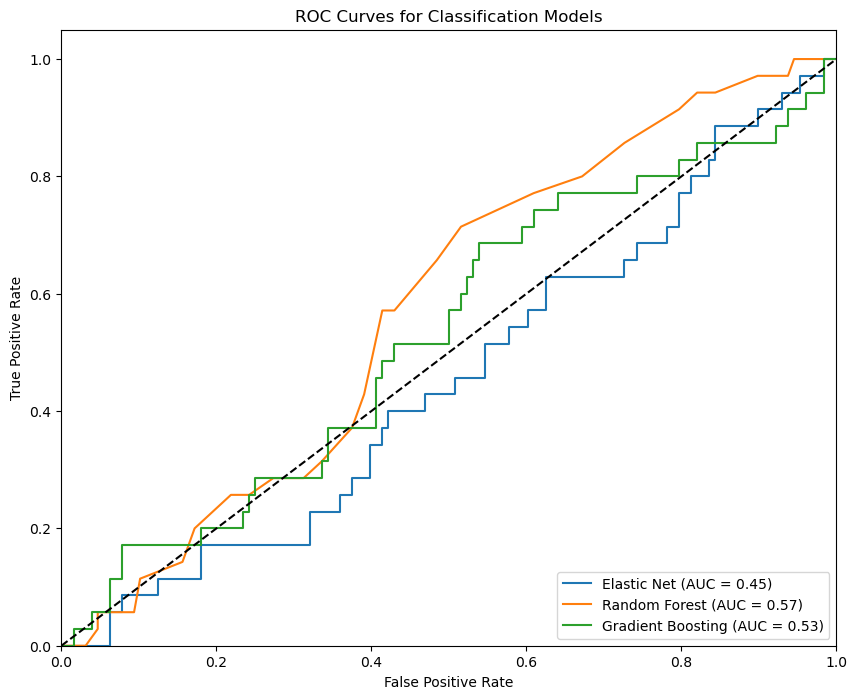

NameError: name 'Sequential' is not defined

In [17]:
# Data Preprocessing Function
def preprocess_data(X, y, task='classification'):
    # Encode categorical labels
    if task == 'classification':
        le = LabelEncoder()
        y = le.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Model Training & Evaluation Function for Classification
def train_evaluate_classification_models(X_train, X_test, y_train, y_test):
    models = {
        'Elastic Net': LogisticRegression(penalty='elasticnet', solver='saga', 
                                        l1_ratio=0.5, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    results = {}
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        
        # Store results
        results[name] = {
            'AUC': roc_auc,
            'Confusion Matrix': confusion_matrix(y_test, y_pred),
            'Classification Report': classification_report(y_test, y_pred)
        }
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Classification Models')
    plt.legend(loc="lower right")
    plt.show()
    
    return results


# Main execution
def main():
    # For top 2% expressed genes
    print("Training models on top 2% expressed genes:")
    
    # Classification
    X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
        rnaseq_df_top_genes, md['HRD_status_base'], task='classification'
    )
    
    results_top = train_evaluate_classification_models(
        X_train_top, X_test_top, y_train_top, y_test_top
    )
    
    # Neural Network
    nn_model_top = create_nn_classifier(rnaseq_df_top_genes.shape[1])
    history_top = nn_model_top.fit(
        X_train_top, y_train_top,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=0
    )
    
    # For differentially expressed genes
    print("\nTraining models on differentially expressed genes:")
    
    X_train_de, X_test_de, y_train_de, y_test_de = preprocess_data(
        deseq_filtered_rna_seq_df, md['HRD_status_base'], task='classification'
    )
    
    results_de = train_evaluate_classification_models(
        X_train_de, X_test_de, y_train_de, y_test_de
    )
    
    # Print results
    print("\nResults for top 2% expressed genes:")
    for model_name, metrics in results_top.items():
        print(f"\n{model_name}:")
        print(f"AUC: {metrics['AUC']:.3f}")
        print("\nClassification Report:")
        print(metrics['Classification Report'])
        print("\nConfusion Matrix:")
        print(metrics['Confusion Matrix'])
    
    print("\nResults for differentially expressed genes:")
    for model_name, metrics in results_de.items():
        print(f"\n{model_name}:")
        print(f"AUC: {metrics['AUC']:.3f}")
        print("\nClassification Report:")
        print(metrics['Classification Report'])
        print("\nConfusion Matrix:")
        print(metrics['Confusion Matrix'])

# For regression task on Confidence values
def train_evaluate_regression_models(X_train, X_test, y_train, y_test):
    models = {
        'Elastic Net': ElasticNet(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        results[name] = {
            'MSE': mse,
            'R2': r2
        }
        
        # Plot actual vs predicted
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Confidence')
        plt.ylabel('Predicted Confidence')
        plt.title(f'{name} - Actual vs Predicted')
        plt.show()
    
    return results

# Run regression models
def run_regression():
    print("\nTraining regression models for Confidence prediction:")
    
    # For top 2% expressed genes
    X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
        rnaseq_df_top_genes, md['Confidence'], task='regression'
    )
    
    results_top_reg = train_evaluate_regression_models(
        X_train_top, X_test_top, y_train_top, y_test_top
    )
    
    print("\nRegression Results for top 2% expressed genes:")
    for model_name, metrics in results_top_reg.items():
        print(f"\n{model_name}:")
        print(f"MSE: {metrics['MSE']:.6f}")
        print(f"R2: {metrics['R2']:.3f}")


main()
run_regression()

Training models on top 2% expressed genes:


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


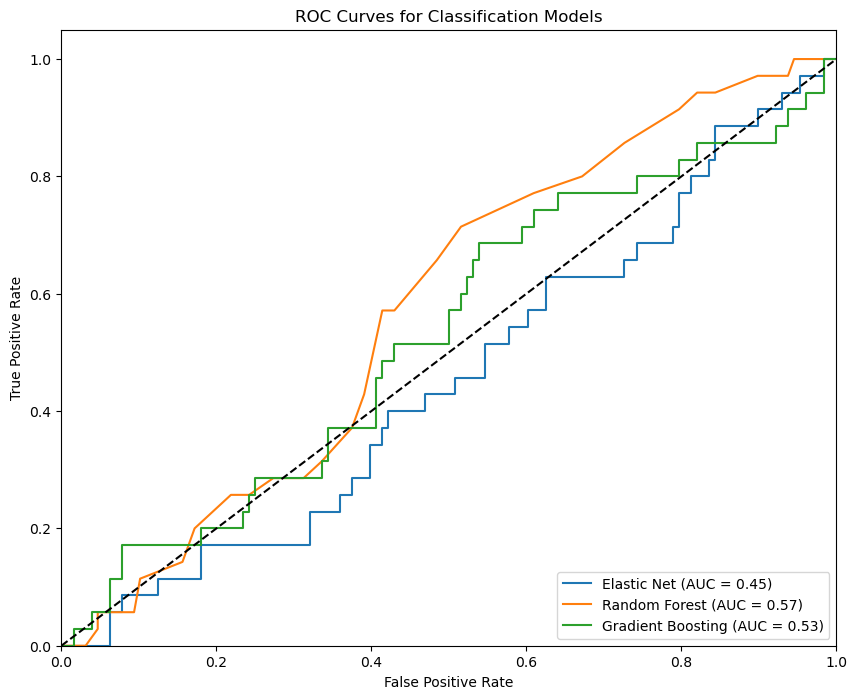


Training models on differentially expressed genes:


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


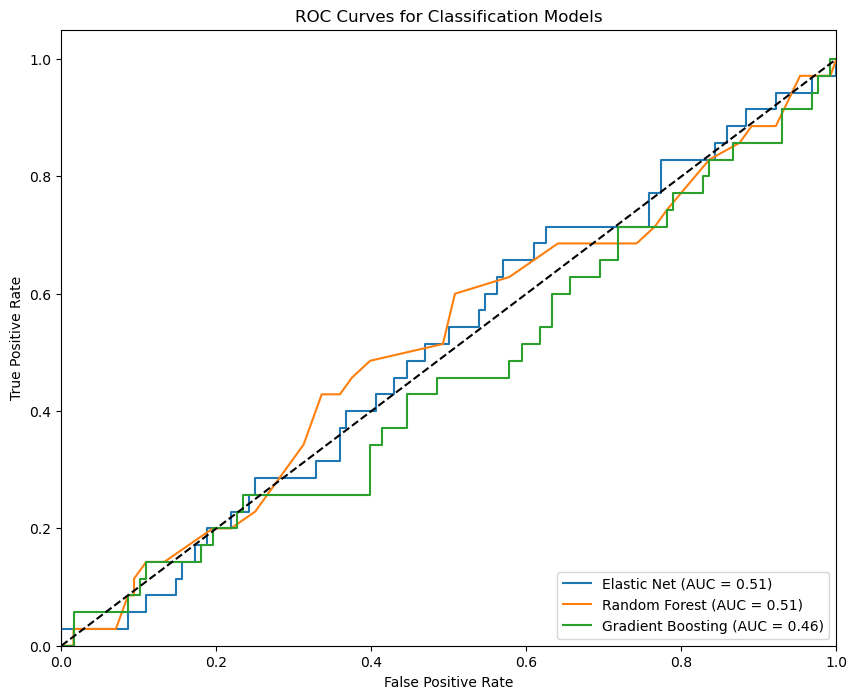


Results for top 2% expressed genes:

Elastic Net:
AUC: 0.453

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.70      0.72       128
           1       0.13      0.17      0.15        35

    accuracy                           0.58       163
   macro avg       0.44      0.43      0.44       163
weighted avg       0.62      0.58      0.60       163


Confusion Matrix:
[[89 39]
 [29  6]]

Random Forest:
AUC: 0.575

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       128
           1       0.00      0.00      0.00        35

    accuracy                           0.77       163
   macro avg       0.39      0.49      0.44       163
weighted avg       0.61      0.77      0.68       163


Confusion Matrix:
[[126   2]
 [ 35   0]]

Gradient Boosting:
AUC: 0.531

Classification Report:
              precision    recall  f1-score   support

           0       

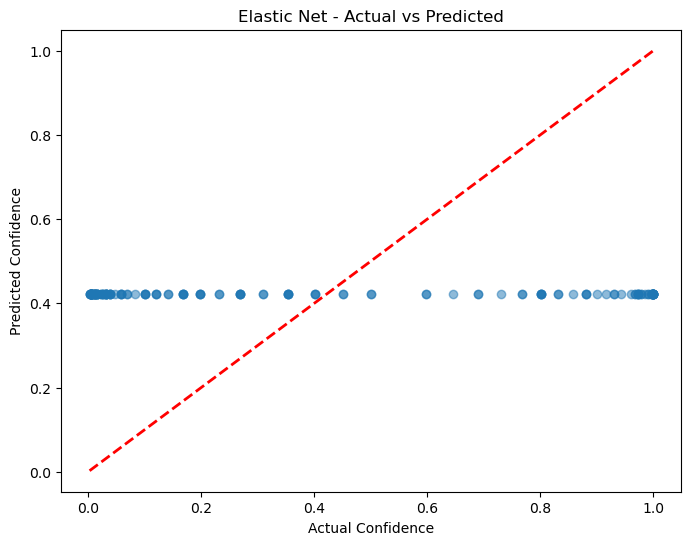

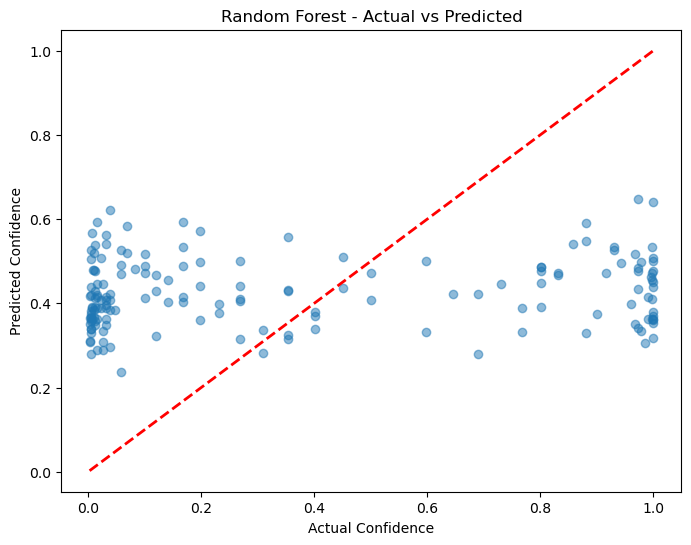

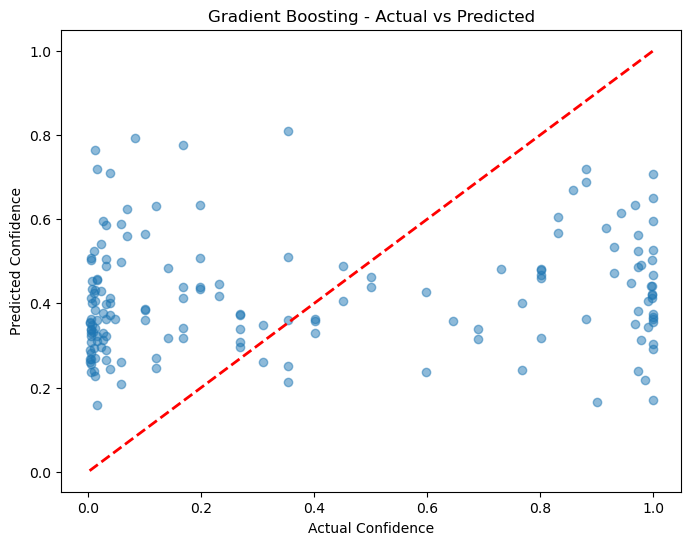


Regression Results for top 2% expressed genes:

Elastic Net:
MSE: 0.162171
R2: -0.013

Random Forest:
MSE: 0.160606
R2: -0.003

Gradient Boosting:
MSE: 0.162794
R2: -0.017


In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing Function
def preprocess_data(X, y, task='classification'):
    # Encode categorical labels
    if task == 'classification':
        le = LabelEncoder()
        y = le.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Model Training & Evaluation Function for Classification
def train_evaluate_classification_models(X_train, X_test, y_train, y_test):
    models = {
        'Elastic Net': LogisticRegression(penalty='elasticnet', solver='saga', 
                                        l1_ratio=0.5, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    results = {}
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        
        # Store results
        results[name] = {
            'AUC': roc_auc,
            'Confusion Matrix': confusion_matrix(y_test, y_pred),
            'Classification Report': classification_report(y_test, y_pred)
        }
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Classification Models')
    plt.legend(loc="lower right")
    plt.show()
    
    return results

# Main execution
def main():
    # For top 2% expressed genes
    print("Training models on top 2% expressed genes:")
    
    # Classification
    X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
        rnaseq_df_top_genes, md['HRD_status_base'], task='classification'
    )
    
    results_top = train_evaluate_classification_models(
        X_train_top, X_test_top, y_train_top, y_test_top
    )
    
    # For differentially expressed genes
    print("\nTraining models on differentially expressed genes:")
    
    X_train_de, X_test_de, y_train_de, y_test_de = preprocess_data(
        deseq_filtered_rna_seq_df, md['HRD_status_base'], task='classification'
    )
    
    results_de = train_evaluate_classification_models(
        X_train_de, X_test_de, y_train_de, y_test_de
    )
    
    # Print results
    print("\nResults for top 2% expressed genes:")
    for model_name, metrics in results_top.items():
        print(f"\n{model_name}:")
        print(f"AUC: {metrics['AUC']:.3f}")
        print("\nClassification Report:")
        print(metrics['Classification Report'])
        print("\nConfusion Matrix:")
        print(metrics['Confusion Matrix'])
    
    print("\nResults for differentially expressed genes:")
    for model_name, metrics in results_de.items():
        print(f"\n{model_name}:")
        print(f"AUC: {metrics['AUC']:.3f}")
        print("\nClassification Report:")
        print(metrics['Classification Report'])
        print("\nConfusion Matrix:")
        print(metrics['Confusion Matrix'])

# For regression task on Confidence values
def train_evaluate_regression_models(X_train, X_test, y_train, y_test):
    models = {
        'Elastic Net': ElasticNet(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        results[name] = {
            'MSE': mse,
            'R2': r2
        }
        
        # Plot actual vs predicted
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Confidence')
        plt.ylabel('Predicted Confidence')
        plt.title(f'{name} - Actual vs Predicted')
        plt.show()
    
    return results

# Run regression models
def run_regression():
    print("\nTraining regression models for Confidence prediction:")
    
    # For top 2% expressed genes
    X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
        rnaseq_df_top_genes, md['Confidence'], task='regression'
    )
    
    results_top_reg = train_evaluate_regression_models(
        X_train_top, X_test_top, y_train_top, y_test_top
    )
    
    print("\nRegression Results for top 2% expressed genes:")
    for model_name, metrics in results_top_reg.items():
        print(f"\n{model_name}:")
        print(f"MSE: {metrics['MSE']:.6f}")
        print(f"R2: {metrics['R2']:.3f}")

main()
run_regression()

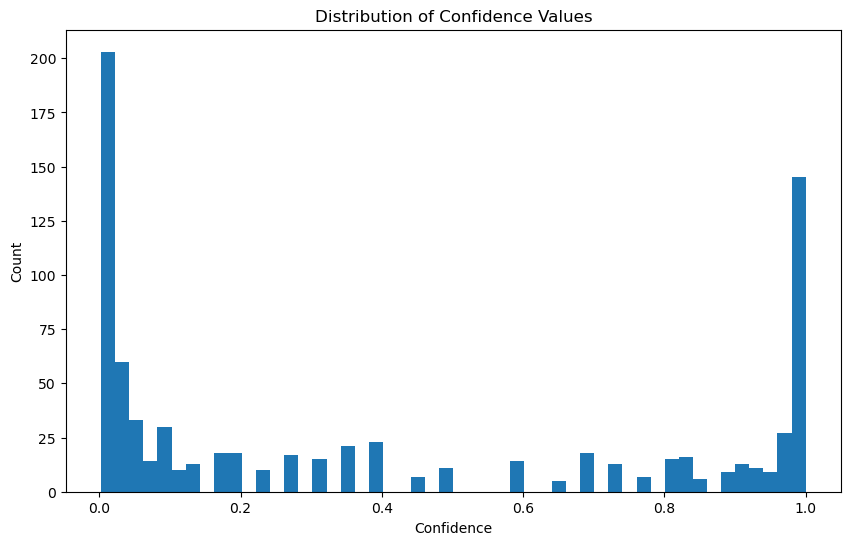


Preparing data...


IndexError: index -1 is out of bounds for axis 0 with size 0

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def identify_high_confidence_samples(confidence_values, threshold_percentile=10):
    """
    Identify high-confidence samples from both ends of the sigmoid distribution
    """
    lower_threshold = np.percentile(confidence_values, threshold_percentile)
    upper_threshold = np.percentile(confidence_values, 100-threshold_percentile)
    
    return (confidence_values <= lower_threshold) | (confidence_values >= upper_threshold)

def preprocess_data(X, confidence_values, threshold_percentile=10):
    """
    Preprocess data using only high confidence samples for training
    """
    # Make sure X and confidence_values have same index
    X = X.copy()
    confidence_values = confidence_values.copy()
    
    # Ensure indices match
    common_index = X.index.intersection(confidence_values.index)
    X = X.loc[common_index]
    confidence_values = confidence_values.loc[common_index]
    
    # Identify high confidence samples
    high_confidence_mask = identify_high_confidence_samples(confidence_values, threshold_percentile)
    
    # Split data into training (high confidence) and validation (remaining) sets
    X_high_conf = X[high_confidence_mask]
    y_high_conf = confidence_values[high_confidence_mask]
    X_ambiguous = X[~high_confidence_mask]
    y_ambiguous = confidence_values[~high_confidence_mask]
    
    # Further split high confidence data into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_high_conf, y_high_conf, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_ambiguous_scaled = scaler.transform(X_ambiguous)
    
    # Convert to dataframes with proper index
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)
    X_ambiguous_scaled = pd.DataFrame(X_ambiguous_scaled, index=X_ambiguous.index, columns=X_ambiguous.columns)
    
    return (X_train_scaled, X_test_scaled, X_ambiguous_scaled, 
            y_train, y_test, y_ambiguous)

def train_evaluate_models(X_train, X_test, X_ambiguous, y_train, y_test, y_ambiguous):
    """
    Train and evaluate models using soft labels
    """
    models = {
        'Linear Regression': LinearRegression(),
        'Elastic Net': ElasticNet(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions for test and ambiguous sets
        y_pred_test = model.predict(X_test)
        y_pred_ambiguous = model.predict(X_ambiguous)
        
        # Calculate metrics
        test_mse = mean_squared_error(y_test, y_pred_test)
        test_r2 = r2_score(y_test, y_pred_test)
        
        # Store results
        results[name] = {
            'Test MSE': test_mse,
            'Test R2': test_r2,
            'Test Predictions': y_pred_test,
            'Ambiguous Predictions': y_pred_ambiguous
        }
        
        # Plot actual vs predicted for test set
        plt.figure(figsize=(15, 5))
        
        # Test set predictions
        plt.subplot(1, 3, 1)
        plt.scatter(y_test, y_pred_test, alpha=0.5)
        plt.plot([0, 1], [0, 1], 'r--', lw=2)
        plt.xlabel('Actual Confidence')
        plt.ylabel('Predicted Confidence')
        plt.title(f'{name} - Test Set Predictions')
        
        # Ambiguous set predictions
        plt.subplot(1, 3, 2)
        plt.hist(y_pred_ambiguous, bins=50, alpha=0.5)
        plt.xlabel('Predicted Confidence')
        plt.ylabel('Count')
        plt.title(f'{name} - Ambiguous Set Predictions')
        
        # ROC curve
        fpr, tpr, _ = roc_curve((y_test > 0.5).astype(int), y_pred_test)
        roc_auc = auc(fpr, tpr)
        
        plt.subplot(1, 3, 3)
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{name} - ROC Curve')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed results
        print(f"\n{name} Results:")
        print(f"Test MSE: {test_mse:.6f}")
        print(f"Test R2: {test_r2:.3f}")
        print(f"ROC-AUC: {roc_auc:.3f}")
        print("\nAmbiguous Predictions Summary:")
        print(f"Mean: {np.mean(y_pred_ambiguous):.3f}")
        print(f"Std: {np.std(y_pred_ambiguous):.3f}")
        print(f"% Predicted HRD (>0.5): {(y_pred_ambiguous > 0.5).mean()*100:.1f}%")
        
    return results

def main():
    # First, let's look at the confidence distribution
    plt.figure(figsize=(10, 6))
    plt.hist(md['Confidence'], bins=50)
    plt.title('Distribution of Confidence Values')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.show()
    
    print("\nPreparing data...")
    # Identify high confidence samples and prepare data
    X_train, X_test, X_ambiguous, y_train, y_test, y_ambiguous = preprocess_data(
        rnaseq_df_top_genes, md['Confidence']
    )
    
    print(f"\nData split sizes:")
    print(f"Training set: {len(X_train)}")
    print(f"Test set: {len(X_test)}")
    print(f"Ambiguous set: {len(X_ambiguous)}")
    
    # Train and evaluate models
    results = train_evaluate_models(
        X_train, X_test, X_ambiguous,
        y_train, y_test, y_ambiguous
    )
    
    return results


results = main()

In [26]:
# Check data alignment and print diagnostic information
print("rnaseq_df_top_genes shape:", pcg_400_with_metadata.shape)
print("md['Confidence'] shape:", md['Confidence'].shape)
print("\nrnaseq_df_top_genes index (first 5):", pcg_400_with_metadata.index[:5].tolist())
print("md['Confidence'] index (first 5):", md['Confidence'].index[:5].tolist())

# Check for common samples
common_samples = set(pcg_400_with_metadata.index) & set(md.index)
print("\nNumber of common samples:", len(common_samples))

rnaseq_df_top_genes shape: (811, 403)
md['Confidence'] shape: (811,)

rnaseq_df_top_genes index (first 5): [0, 1, 3, 4, 5]
md['Confidence'] index (first 5): ['TCGA-A1-A0SB', 'TCGA-A1-A0SD', 'TCGA-A1-A0SE', 'TCGA-A1-A0SF', 'TCGA-A1-A0SG']

Number of common samples: 0
